# Session 12: Recurrent Neural Networks

### Problem 1: Recursive Substitution of RNN
See Notes

### Problem 2: Equivalent feedforward architecture instead of an RNN:

Any function involving recurrence can be considered a recurrent neural network. As a feedforward network, the NN could just be represented as an unfolded computational graph, in which each component is represented by many different variables, with one variable per time step, representing the state of the component at that point in time.

Function g(t) takes the whole past sequence as input and produces the current state, but the unfolded recurrent structure allows us to factorize g(t) into repeated application of a function f. 2 advantages with unfolding:
- Learned model always has the same input size because it is specified in terms of transition from one state to another state (rather than in terms of a variable length history of states
- Possible to use the *same* transition function f with the same parameters at every time step

This way we do not need to learn a separate model for all possible time steps

### Problem 3: Design patterns that can be used with RNN

Could do a One to many and then many to one approach. One to one is 'vanilla'. One to many, many to one, many to many, many to many(equivalence)

- Recurrent Networks that produce an output at each time step and have recurrent connections between hidden units
- Produce an output at each time step and have recurrent connections only from the output at one time step to the hidden units at the next time step
- Recurrent networks with recurrent connections between hidden units, that read an entire sequence then produce a single output

### Problem 4: Design Pattern in the Unreasonable Effectiveness of RNNs

Design examples are the one to one or one to many or many to one approaches already discussed

### Problem 5: Difference between RNN and LSTM
**RNN's have recurrent connections and/or layers**

RNN is almost always described as a Neural Network and not as any specific layer.

**LSTM can refer to a unit, layer or Neural Network**

Note that an LSTM unit is a recurrent unit. So an LSTM neural network is a recurrent neural network. 

The difference is that LSTM is composed of so called 'gates' that supposedly regulate better the flow of information through the unit. We could have four different types of gates:
- Forget gate: whether to erase a cell(from previous state)
- Input gate: whether to write to cell
- Gate gate: how much to write to (input) cell
- Output gate: how much to reveal cell

Also contains two hidden states at every time step:
- Hidden state similar to vanilla RNN
- Cell state is a vector that is internal, inside the LSTM, not exposed to the outside world
Use gates to update our cell state ct. Then expose part of the cell for the hidden state.

Take previous hidden state, stack, then multiply by a weight matrix to compute the four different states(gates). Each gte could use a different nonlinearity

### Problem 6: Exploding and Vanishing Gradient Problem
LSTM was designed specifically to remove the vanishing gradient problem in backprop. Final expression for gradient on $h_0$ will involve many factors of the weight matrix.
- Several hundred examples would yield bad results (not little factors)
- either explode in the case $w>1$ or vanish in case $w<1$ in absolute value
- In the matrix case, largest singular value of the weight matrix must meet these conditions

Could hack the system to avoid this by using a gradient clipping

`grad_norm = np.sum(grad*grad)    
if grad_norm > threshold:         
    grad *= (threshold/grad_norm)`
    
**Gradient Clipping**: After we compute our gradient, if the L2 norm is above a certain threshold, then just clamp it down so it has a maximum threshold (Works in the case of exploding gradient problem)

### Problem 7: Vanishing Gradient Problem

**Vanishing Gradient Problem**: Change the RNN architecture

**Long Short Term Memory**: alleviates the vanishing gradient problem
- We maintain two hidden steps to have better gradient flow
- $h_t$ and $c_t$ are formed, which is a previous cell state and previous input state

$$ h_t = o \dot tanh(c_t) $$
$$ c_t = f \dot c_{t-1} + i \dot g $$

- forget gate, input gate, gate gate, output gate
- when we go through a backwards pass, we completely ignore the weight matrix W

Due to nonlinearities, if forget gates are always less than one, then you could get vanishing gradients as you continuously go through forget gates. Could initialize biases of forget gate to be somewhat positive. Forget gates would always be close to one. Still better than vanilla RNN as f's can vary at each time step (unlike weight matrix) and because element wise multiplication rather than full matrix multiplications.

### Problem 8: Batch size
Batch sizes are important because of computational issues. It is much more computationally heavy to back propagate through the whole RNN than it is to back propagate through batches.

- Another reason is that because this is supervised learning, we need to give the input and output beforehand.
- Needs a sequence of data, 3 months or 12 months, then it would make a prediction using this input size
- Batches are just how many time periods in the past the neural network model will consider

### Problem 9: Generate 600 samples from an AR model

$$ X_t = a_1 X_{t-1} + a_2 X_{t-2} + a_3 X_{t-3}$$

In [2]:
!pip install statsmodels

You should consider upgrading via the '/Users/Ivan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

In [110]:
### Generation of data

in_array = np.linspace(0, 2 * np.pi, 600)
y = list(np.random.uniform(0,0.1,3))

e = np.random.uniform(0,0.1,600)

for i in range(len(in_array)):
    y.append(0.6*y[-1] - 0.5*y[-2] - 0.2*y[-3] + np.random.uniform(0,0.1))
    i += 1

x1 = [0]
x2 = [0, 0]
x3 = [0, 0, 0]


for j in y:
    x1.append(j)
    x2.append(j)
    x3.append(j)

x1.pop(-1)
x2.pop(-1)
x2.pop(-1)
x3.pop(-1)
x3.pop(-1)
x3.pop(-1)

x2
df = pd.DataFrame(
    {'Y': y,
    'Yt1': x1,
    'Yt2': x2,
    'Yt3': x3})
df.head()

,Y,Yt1,Yt2,Yt3
0,0.077159,0.000000,0.000000,0.000000
1,0.050742,0.077159,0.000000,0.000000
2,0.034782,0.050742,0.077159,0.000000
3,-0.006829,0.034782,0.050742,0.077159
4,0.048799,-0.006829,0.034782,0.050742


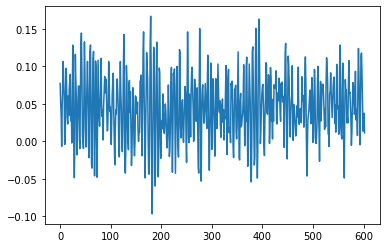

In [114]:
plt.plot(df.Y)

#### Preprocessing

In [144]:
import sklearn
from sklearn.model_selection import train_test_split # split the data into training and testing
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # creates support vector machine for classification
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

In [116]:
X = df.drop('Y', axis=1).copy()
X.head()

,Yt1,Yt2,Yt3
0,0.000000,0.000000,0.000000
1,0.077159,0.000000,0.000000
2,0.050742,0.077159,0.000000
3,0.034782,0.050742,0.077159
4,-0.006829,0.034782,0.050742


In [180]:
y = df['Y'].copy()
len(y)

603

In [193]:
X_train, X_test, y_train, y_test = X.head(452).copy(), X.tail(151).copy(), y.head(452).copy(), y.tail(151).copy()
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

TypeError: 'MinMaxScaler' object is not callable

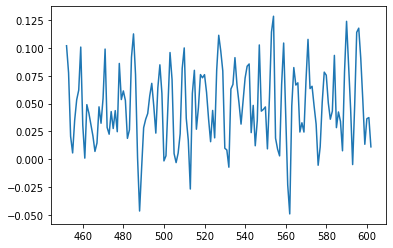

In [131]:
plt.plot(y_test)

In [194]:
y_flatten = y.values[0:].reshape(-1,1)
y_flatten

# scale the data -- this avoids the exploding gradient problem

scale = MinMaxScaler(feature_range = (0,1))
y_flatten = scale.fit_transform(y_flatten)

#### Architecture of RNN

In [149]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [195]:
samples = 10  # number of samples (in past)
steps = 1  # number of steps (in future)
x_array = []
y_array = []
for k in range(y_flatten.shape[0] - samples):
    x_array.append(y_flatten[k:k+samples])  # independent samples
    y_array.append(y_flatten[k+samples][0]) # dependent samples
print('Training Data: Length is ', len(x_array[0:1][0]),': ', x_array[0:1])
print('Testing Data: Length is ', len(y_array[0:1]),': ', y_array[0:1])

Training Data: Length is  10 :  [array([[0.66020863],
       [0.55995501],
       [0.49938846],
       [0.34146981],
       [0.5525812 ],
       [0.6359593 ],
       [0.77184288],
       [0.66604698],
       [0.59215922],
       [0.35140198]])]
Testing Data: Length is  1 :  [0.3565209199273157]


Essentially, we will use the last 10 values of the training data in order to try and predict the testing set

In [196]:
X_reshape = np.array(x_array)
Y_reshape = np.array(y_array)
print('Dimensions of X', X_reshape.shape, 'Dimensions of Y', Y_reshape.shape)

threshold = round(0.9 * X_reshape.shape[0])
print('Threshold is ', threshold)

Dimensions of X (593, 10, 1) Dimensions of Y (593,)
Threshold is  534


In [197]:
trainX, trainY = X_reshape[:threshold], Y_reshape[:threshold]
testX, testY = X_reshape[threshold:], Y_reshape[threshold:]

90% of the data will be used as training data

#### Building the RNN

In [198]:
model = keras.Sequential()

# Add an RNN layer with 3 units
model.add(layers.SimpleRNN(3,
                          activation = 'tanh',
                          input_shape = (trainX.shape[1], trainX.shape[2])))

# Add a dropout layer (penalize more complex models)
model.add(layers.Dropout(rate=0.2))

# add a Dense laer with 1 unit (since we are doing a regression)
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# print out architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [199]:
# fitting the data
history = model.fit(trainX[:threshold],
                    trainY[:threshold],
                    shuffle = False,  # since this is time series data
                    epochs = 100,
                    batch_size = 32,
                    validation_split = 0.2,
                   verbose = 1)  # verbose outputs data

Epoch 1/100
14/14 [==============================] - 2s 28ms/step - loss: 0.1974 - val_loss: 0.1597
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.1553 - val_loss: 0.1196
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.1224 - val_loss: 0.0862
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0999 - val_loss: 0.0611
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0767 - val_loss: 0.0441
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0714 - val_loss: 0.0339
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0632 - val_loss: 0.0288
Epoch 8/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0577 - val_loss: 0.0268
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0525 - val_loss: 0.0255
Epoch 10/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0563 - val_loss: 0.0245
Epoch 11

Epoch 83/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 0.0117
Epoch 84/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0116
Epoch 85/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0116
Epoch 86/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0191 - val_loss: 0.0115
Epoch 87/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0185 - val_loss: 0.0114
Epoch 88/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0112
Epoch 89/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0176 - val_loss: 0.0114
Epoch 90/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0187 - val_loss: 0.0114
Epoch 91/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.0113
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0187 - val_loss: 0.0112


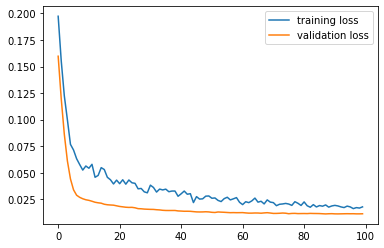

In [200]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

# Note:
# If training loss >> validation loss -> Underfitting
# If training loss << validation loss -> Overfitting
# Several ways to address overfitting:
# Reduce the complexity of the model
# Add dropout and tune rate
# More data

#### One step ahead forecast

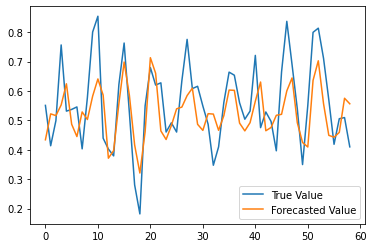

In [201]:
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

#### Multi Step Forecast

In [202]:
# Predictions using the 'sliding/rolling window' approach
# Multi-step forecast
# using self predictions for making future predictions

true_Y = Y_reshape[threshold:]
pred_Y = []
print('Number of Forecasts to do: ', Y_reshape.shape[0] - round(Y_reshape[0]*0.9))
latest_input = X_reshape[threshold - 1:threshold]
for i in range(Y_reshape.shape[0] - round(Y_reshape.shape[0]*0.9)):
    # prediction
    p = model.predict(latest_input.reshape(1, X_reshape.shape[1], 1))[0,0]
    
    #Update predictions
    pred_Y.append(p)
    latest_input = np.append(X_reshape[threshold][1:], p)

Number of Forecasts to do:  593


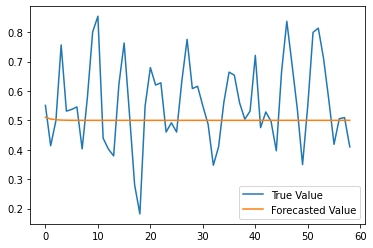

In [203]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()

#### Why do we discard the first 100 samples then re-estimate the RNN?

I can only imagine that it is because the RNN is 'forgetful' and sometimes it may better classify on shorter data

In [185]:
# Discard first 100 samples
y_flatten_trimmed = y.values[0:503].reshape(-1,1)
y_flatten_trimmed

# scale the data -- this avoids the exploding gradient problem

scale = MinMaxScaler(feature_range = (0,1))
y_flatten_trimmed = scale.fit_transform(y_flatten_trimmed)

In [186]:
X_trimmed = []
Y_trimmed = []
for k in range(y_flatten_trimmed.shape[0] - samples):
    X_trimmed.append(y_flatten_trimmed[k:k+samples])  # independent samples
    Y_trimmed.append(y_flatten_trimmed[k+samples][0]) # dependent samples
print('Training Data: Length is ', len(X_trimmed[0:1][0]),': ', X_trimmed[0:1])
print('Testing Data: Length is ', len(Y_trimmed[0:1]),': ', Y_trimmed[0:1])

Training Data: Length is  10 :  [array([[0.66020863],
       [0.55995501],
       [0.49938846],
       [0.34146981],
       [0.5525812 ],
       [0.6359593 ],
       [0.77184288],
       [0.66604698],
       [0.59215922],
       [0.35140198]])]
Testing Data: Length is  1 :  [0.3565209199273157]


In [187]:
X_reshape_trimmed = np.array(X_trimmed)
Y_reshape_trimmed = np.array(Y_trimmed)
print('Dimensions of X', X_reshape_trimmed.shape, 'Dimensions of Y', Y_reshape_trimmed.shape)

threshold_trimmed = round(0.9 * X_reshape_trimmed.shape[0])
print('Threshold is ', threshold_trimmed)

Dimensions of X (493, 10, 1) Dimensions of Y (493,)
Threshold is  444


In [188]:
trainX_trimmed, trainY_trimmed = X_reshape_trimmed[:threshold_trimmed], Y_reshape_trimmed[:threshold_trimmed]
testX_trimmed, testY_trimmed = X_reshape_trimmed[threshold_trimmed:], Y_reshape_trimmed[threshold_trimmed:]

In [189]:
model_trimmed = keras.Sequential()

# Add an RNN layer with 3 units
model_trimmed.add(layers.SimpleRNN(3,
                          activation = 'tanh',
                          input_shape = (trainX_trimmed.shape[1], trainX_trimmed.shape[2])))

# Add a dropout layer (penalize more complex models)
model_trimmed.add(layers.Dropout(rate=0.2))

# add a Dense laer with 1 unit (since we are doing a regression)
model_trimmed.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer
model_trimmed.compile(loss = 'mean_squared_error', optimizer = 'adam')

# print out architecture
model_trimmed.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [190]:
# fitting the data
history_trimmed = model_trimmed.fit(trainX_trimmed[:threshold_trimmed],
                    trainY_trimmed[:threshold_trimmed],
                    shuffle = False,  # since this is time series data
                    epochs = 100,
                    batch_size = 32,
                    validation_split = 0.2,
                   verbose = 1)  # verbose outputs data

Epoch 1/100
12/12 [==============================] - 2s 38ms/step - loss: 0.1392 - val_loss: 0.0857
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 0.1319 - val_loss: 0.0742
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1153 - val_loss: 0.0659
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0996 - val_loss: 0.0595
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0966 - val_loss: 0.0546
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0929 - val_loss: 0.0508
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0892 - val_loss: 0.0480
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0818 - val_loss: 0.0460
Epoch 9/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0799 - val_loss: 0.0444
Epoch 10/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0818 - val_loss: 0.0431
Epoc

12/12 [==============================] - 0s 8ms/step - loss: 0.0181 - val_loss: 0.0167
Epoch 83/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0189 - val_loss: 0.0165
Epoch 84/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.0165
Epoch 85/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0189 - val_loss: 0.0163
Epoch 86/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0176 - val_loss: 0.0163
Epoch 87/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0175 - val_loss: 0.0162
Epoch 88/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0174 - val_loss: 0.0159
Epoch 89/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0158
Epoch 90/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 91/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0185 - val_loss: 0.0160
Epoch 92/100

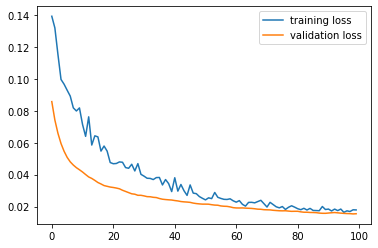

In [191]:
# Plotting the loss iteration
plt.plot(history_trimmed.history['loss'], label = 'training loss')
plt.plot(history_trimmed.history['val_loss'], label = 'validation loss')
plt.legend()

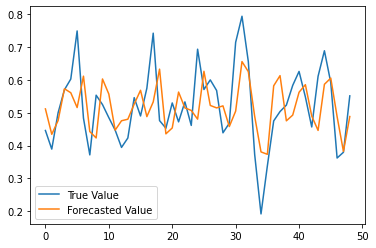

In [192]:
y_pred_trimmed = model_trimmed.predict(testX_trimmed)
plt.plot(testY_trimmed, label = 'True Value')
plt.plot(y_pred_trimmed, label = 'Forecasted Value')
plt.legend()

If we compare the val_loss of both models, we see that model_trimmed has a final val_loss of 0.0155 and model has a final val_loss of 0.0114

#### Building an LSTM
We will use the full data in this case. This is callable from the y data set we defined before

In [240]:
df_melted = df.Y
type(df_melted)
lstm_df = df_melted.to_frame()

,Y
0,0.077159
1,0.050742
2,0.034782
3,-0.006829
4,0.048799
...,...
598,0.053489
599,0.013511
600,0.036463
601,0.037491


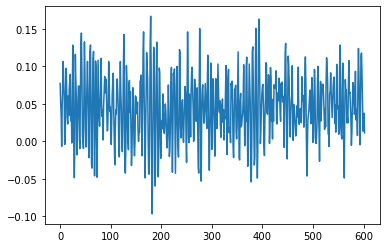

In [241]:
plt.plot(lstm_df)

In [242]:
lstm_train = lstm_df.iloc[:543]
lstm_test = lstm_df.iloc[543:]

Interesting side note: RNNs don't actually require the data to be stationary. They can consider complex patterns much more easily.

#### Preprocessing

In [243]:
lstm_scaler = MinMaxScaler()

In [244]:
lstm_df.head(), lstm_df.tail()

(          Y
 0  0.077159
 1  0.050742
 2  0.034782
 3 -0.006829
 4  0.048799,
             Y
 598  0.053489
 599  0.013511
 600  0.036463
 601  0.037491
 602  0.011212)

In [245]:
lstm_scaler.fit(lstm_train)
lstm_scaled_train = lstm_scaler.transform(lstm_train)
lstm_scaled_test = lstm_scaler.transform(lstm_test)

Like always, we want to scale the model because there may be large differences in values from the first time point through the last time point.

In [246]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [255]:
# Define Generator
n_input = 12  # Consider 12 periods in the past
n_features = 1  # Can increase if you have multiple time series
generator = TimeseriesGenerator(lstm_scaled_train, lstm_scaled_train, length = n_input, batch_size = 1)

In [256]:
print(len(lstm_scaled_train), len(generator))

543 531


In [257]:
new_X, new_Y = generator[0]
print(f'Given the Array: \n{new_X.flatten()}')
print(f'Predict this y: \n {new_Y}')

Given the Array: 
[0.66020863 0.55995501 0.49938846 0.34146981 0.5525812  0.6359593
 0.77184288 0.66604698 0.59215922 0.35140198 0.35652092 0.67327795]
Predict this y: 
 [[0.73706296]]


In [253]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [259]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
lstm_model.add(Dense(1))  # final layer to make prediction
lstm_model.compile(optimizer = 'adam', loss = 'mse')

In [260]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [265]:
lstm_model.fit(generator, epochs = 50)

Epoch 1/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0117
Epoch 2/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0118
Epoch 3/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0116
Epoch 4/50
531/531 [==============================] - 4s 8ms/step - loss: 0.0117
Epoch 5/50
531/531 [==============================] - 4s 8ms/step - loss: 0.0119
Epoch 6/50
531/531 [==============================] - 5s 9ms/step - loss: 0.0122
Epoch 7/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0116
Epoch 8/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0117
Epoch 9/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0117
Epoch 10/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0115
Epoch 11/50
531/531 [==============================] - 4s 8ms/step - loss: 0.0117
Epoch 12/50
531/531 [==============================] - 4s 7ms/step - loss: 0.0115
Epoch 13/50
531/531 [====

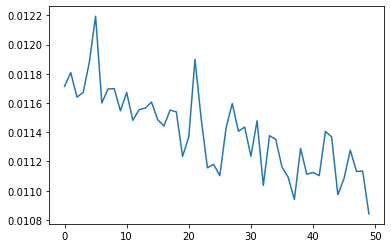

In [266]:
loss_per_epoch = lstm_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [267]:
last_train_batch = lstm_scaled_train[-12:]

In [268]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [269]:
lstm_model.predict(last_train_batch)

array([[0.5837765]], dtype=float32)

In [270]:
lstm_scaled_test[0]

array([0.45841215])

In [272]:
lstm_predictions = []

first_eval_batch = lstm_scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(lstm_test)):
    
    # get prediction value for current batch
    current_pred = lstm_model.predict(current_batch)[0]
    
    # append the prediction to the array
    lstm_predictions.append(current_pred)
    
    # use the prediction to update the batches
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [274]:
lstm_predictions

[array([0.5837765], dtype=float32),
 array([0.5090978], dtype=float32),
 array([0.5279521], dtype=float32),
 array([0.6089308], dtype=float32),
 array([0.66104716], dtype=float32),
 array([0.64072204], dtype=float32),
 array([0.582845], dtype=float32),
 array([0.5488568], dtype=float32),
 array([0.5640714], dtype=float32),
 array([0.6046592], dtype=float32),
 array([0.6254674], dtype=float32),
 array([0.6077715], dtype=float32),
 array([0.5778438], dtype=float32),
 array([0.5688747], dtype=float32),
 array([0.58520156], dtype=float32),
 array([0.6048902], dtype=float32),
 array([0.60675794], dtype=float32),
 array([0.59122247], dtype=float32),
 array([0.57748425], dtype=float32),
 array([0.57982755], dtype=float32),
 array([0.59292483], dtype=float32),
 array([0.60146105], dtype=float32),
 array([0.5969473], dtype=float32),
 array([0.5856564], dtype=float32),
 array([0.5806791], dtype=float32),
 array([0.5860677], dtype=float32),
 array([0.5945008], dtype=float32),
 array([0.5969237], 

In [275]:
lstm_test.head()

,Y
543,0.023985
544,0.048409
545,0.012198
546,0.034746
547,0.102625


In [277]:
true_predictions = lstm_scaler.inverse_transform(lstm_predictions)

In [278]:
lstm_test['Predictions'] = true_predictions

/var/folders/bk/vwbh8wcn0bdg18n5f30xdrf00000gn/T/ipykernel_47808/148945012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_test['Predictions'] = true_predictions


<AxesSubplot:>

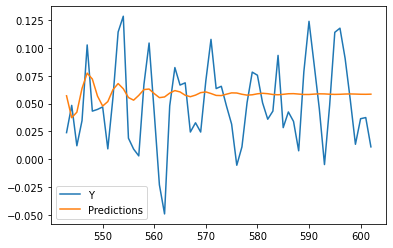

In [279]:
lstm_test.plot()